<a href="https://colab.research.google.com/github/Fontesx11/AR/blob/main/Teste_de_Pol%C3%ADticas_de_treinamento_para_o_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importação de bibliotecas

In [ ]:
# -----------------
# IMPORTAÇÃO DAS BIBLIOTECAS NECESSÁRIAS
# -----------------

import numpy as np  # Biblioteca para manipulação de arrays e cálculos numéricos
import gymnasium as gym  # Ambiente de simulação do OpenAI Gymnasium
import matplotlib.pyplot as plt  # Biblioteca para visualização de dados

# 2. Definição das políticas de escolha de ações

In [ ]:
# -----------------
# POLÍTICAS DE ESCOLHA DE AÇÕES
# -----------------

import numpy as np

def epsilon_greedy_probs(Q, state, epsilon):
    """
    Calcula as probabilidades de escolha de cada ação usando a política epsilon-greedy.

    Parâmetros:
        Q (np.array): Tabela Q de valores de ação-estado.
        state (int): Estado atual.
        epsilon (float): Probabilidade de exploração (tomar uma ação aleatória).

    Retorna:
        np.array: Probabilidades de seleção de cada ação.
    """
    Q_state = Q[state]  # Obtém os valores Q para o estado atual
    num_actions = len(Q_state)  # Quantidade de ações possíveis
    q_max = np.max(Q_state)  # Maior valor Q para o estado

    non_greedy_action_probability = epsilon / num_actions  # Probabilidade das ações não ótimas
    greedy_actions = np.sum(Q_state == q_max)  # Conta quantas ações possuem o valor máximo

    greedy_action_probability = ((1 - epsilon) / greedy_actions) + non_greedy_action_probability
    probs = np.where(Q_state == q_max, greedy_action_probability, non_greedy_action_probability)

    return probs

def epsilon_greedy_choice(Q, state, epsilon):
    """
    Escolhe uma ação usando a política epsilon-greedy.
    """
    probs = epsilon_greedy_probs(Q, state, epsilon)
    return np.random.choice(len(Q[state]), p=probs)

def random_choice(Q, state):
    """
    Escolhe uma ação aleatoriamente.
    """
    return np.random.choice(len(Q[state]))

def softmax_probs(Q, state, tau=1.0):
    """
    Calcula as probabilidades de escolha de cada ação usando a política Softmax.
    """
    values = Q[state] - np.max(Q[state])  # Evita valores muito grandes para estabilidade numérica
    values = np.exp(values / tau)  # Aplica a função exponencial com fator de temperatura tau
    return values / np.sum(values)  # Normaliza para obter uma distribuição de probabilidade

def softmax_choice(Q, state, tau=1.0):
    """
    Escolhe uma ação usando a política Softmax.
    """
    probs = softmax_probs(Q, state, tau)
    return np.random.choice(len(probs), p=probs)

def ucb_choice(Q, state, action_cnt, total_steps, c=2.0):
    """
    Escolhe uma ação usando a política Upper Confidence Bound (UCB).

    Parâmetros:
        Q (np.array): Tabela Q de valores de ação-estado.
        state (int): Estado atual.
        action_cnt (np.array): Contador de execução de cada ação.
        total_steps (int): Quantidade total de passos já tomados.
        c (float): Parâmetro de exploração da UCB.

    Retorna:
        int: Ação escolhida.
    """
    num_actions = len(Q[state])  # Obtém o número de ações disponíveis

    # Primeiro, escolhe todas as ações pelo menos uma vez para garantir diversificação inicial
    if total_steps < num_actions:
        return total_steps

    # Calcula os valores UCB para todas as ações e retorna a ação com maior valor
    ucb_values = Q[state] + c * np.sqrt(np.log(total_steps) / (action_cnt[state] + 1e-5))
    return np.argmax(ucb_values)

# 3. Implementação do Q-Learning

In [ ]:
# -----------------
# IMPLEMENTAÇÃO DO Q-LEARNING
# -----------------

def run_qlearning(env, episodes, lr=0.1, gamma=0.95, policy='epsilon-greedy', epsilon=0.1, tau=1.0, c=2.0):
    """
    Executa o algoritmo Q-Learning para aprendizado de reforço.

    Parâmetros:
        env: Ambiente de aprendizado (seguindo a interface OpenAI Gym).
        episodes: Número de episódios de treinamento.
        lr: Taxa de aprendizado (learning rate).
        gamma: Fator de desconto para recompensas futuras.
        policy: Política de seleção de ações ('epsilon-greedy', 'random', 'softmax', 'ucb').
        epsilon: Parâmetro para a política epsilon-greedy.
        tau: Parâmetro para a política softmax.
        c: Parâmetro para a política UCB (Upper Confidence Bound).

    Retorna:
        all_episode_rewards: Lista com as recompensas obtidas em cada episódio.
        Q: Tabela Q atualizada após o treinamento.
    """
    num_actions = env.action_space.n  # Obtém o número de ações possíveis no ambiente

    # Inicializa a tabela Q com valores pequenos aleatórios
    Q = np.random.uniform(low=-0.01, high=0.01, size=(env.observation_space.n, num_actions))

    # Contador de escolhas de cada ação para a política UCB
    action_cnt = np.zeros((env.observation_space.n, num_actions))

    all_episode_rewards = []  # Lista para armazenar as recompensas obtidas em cada episódio
    total_steps = 0  # Contador total de passos tomados

    for episode in range(episodes):
        done = False  # Variável para indicar se o episódio terminou
        state, _ = env.reset()  # Reinicia o ambiente e obtém o estado inicial
        sum_rewards = 0  # Soma das recompensas do episódio

        while not done:
            # Escolha de ação conforme a política selecionada
            if policy == 'epsilon-greedy':
                action = epsilon_greedy_choice(Q, state, epsilon)
            elif policy == 'random':
                action = random_choice(Q, state)
            elif policy == 'softmax':
                action = softmax_choice(Q, state, tau)
            elif policy == 'ucb':
                action = ucb_choice(Q, state, action_cnt, total_steps, c)
            else:
                raise ValueError("Política desconhecida")

            # Executa a ação no ambiente e obtém o novo estado e recompensa
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # O episódio termina se o estado for terminal

            # Atualiza a tabela Q usando a equação do Q-Learning
            best_next_action = np.argmax(Q[next_state])  # Melhor ação no próximo estado
            Q[state, action] = Q[state, action] + lr * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])

            # Atualiza os contadores e soma as recompensas
            sum_rewards += reward
            state = next_state
            total_steps += 1
            action_cnt[state, action] += 1  # Contabiliza a seleção da ação

        all_episode_rewards.append(sum_rewards)  # Armazena a recompensa total do episódio

    return all_episode_rewards, Q

# 4. Avaliação da política treinada

In [ ]:
# -----------------
# AVALIAÇÃO DAS POLÍTICAS
# -----------------

def evaluate_policy(env, Q, episodes=10):
    # Lista para armazenar as recompensas obtidas em cada episódio
    total_rewards = []
    # Contador do total de passos executados ao longo dos episódios
    total_steps = 0

    # Loop principal para avaliar a política por um número fixo de episódios
    for ep in range(episodes):
        done = False  # Flag para indicar se o episódio terminou
        state, _ = env.reset()  # Reinicia o ambiente e obtém o estado inicial
        sum_rewards = 0  # Soma das recompensas acumuladas no episódio
        steps = 0  # Contador de passos dentro do episódio

        # Executa o episódio até que o ambiente sinalize o término
        while not done:
            action = np.argmax(Q[state])  # Escolhe sempre a melhor ação segundo a tabela Q
            next_state, reward, terminated, truncated, _ = env.step(action)  # Executa a ação no ambiente
            done = terminated or truncated  # Verifica se o episódio terminou
            sum_rewards += reward  # Acumula a recompensa recebida
            state = next_state  # Atualiza o estado para o próximo passo
            steps += 1  # Incrementa o contador de passos

        # Armazena a recompensa total obtida no episódio
        total_rewards.append(sum_rewards)
        total_steps += steps  # Atualiza o total de passos executados

        print(f"Episódio {ep+1}: {sum_rewards:.1f}")  # Exibe a recompensa final do episódio

    # Calcula estatísticas da avaliação
    mean_return = np.mean(total_rewards)  # Média das recompensas
    std_return = np.std(total_rewards)  # Desvio padrão das recompensas

    # Exibe os resultados finais da avaliação
    print(f"\nÚltimos resultados: media = {mean_return:.2f}, desvio padrao = {std_return:.6f}")
    print(f"Retorno médio (por episódio): {mean_return:.2f}, episódios: {episodes}, total de passos: {total_steps}")

    return mean_return  # Retorna a média das recompensas obtidas

# 5. Rodando os experimentos para diferentes ambientes

FrozenLake


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 0.0
Episódio 2: 0.0
Episódio 3: 1.0
Episódio 4: 1.0
Episódio 5: 0.0
Episódio 6: 1.0
Episódio 7: 1.0
Episódio 8: 0.0
Episódio 9: 0.0
Episódio 10: 1.0

Últimos resultados: media = 0.50, desvio padrao = 0.500000
Retorno médio (por episódio): 0.50, episódios: 10, total de passos: 303

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 0.0
Episódio 2: 0.0
Episódio 3: 1.0
Episódio 4: 0.0
Episódio 5: 1.0
Episódio 6: 0.0
Episódio 7: 0.0
Episódio 8: 1.0
Episódio 9: 1.0
Episódio 10: 1.0

Últimos resultados: media = 0.50, desvio padrao = 0.500000
Retorno médio (por episódio): 0.50, episódios: 10, total de passos: 343

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 1.0
Episódio 2: 0.0
Episódio 3: 1.0
Episódio 4: 1.0
Episódio 5: 0.0
Episódio 6: 1.0
Episódio 7: 1.0
Episódio 8: 1.0
Episódio 9: 1.0
Episódio 

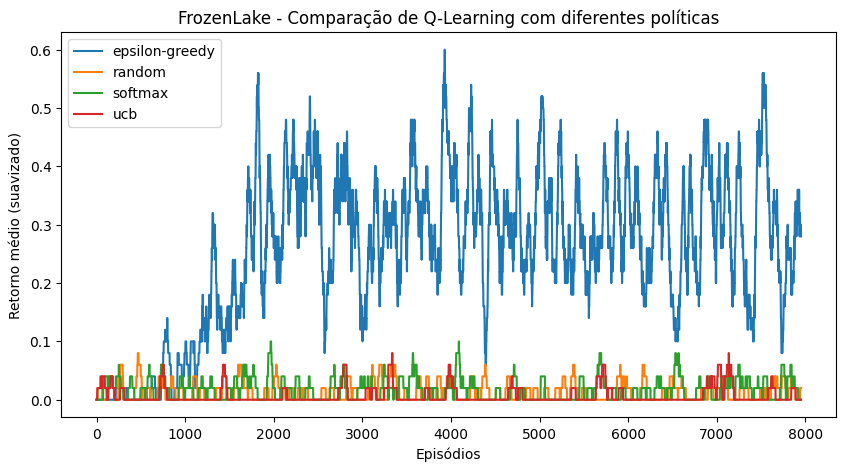

In [ ]:
# -----------------
# EXPERIMENTO 1: FrozenLake
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "FrozenLake-v1"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamentoa
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.95  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("FrozenLake - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

CliffWalking

In [ ]:
# -----------------
# EXPERIMENTO 2: CliffWalking
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "CliffWalking-v0"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamento
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.95  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("CliffWalking - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: -13.0
Episódio 2: -13.0
Episódio 3: -13.0
Episódio 4: -13.0
Episódio 5: -13.0
Episódio 6: -13.0
Episódio 7: -13.0
Episódio 8: -13.0
Episódio 9: -13.0
Episódio 10: -13.0

Últimos resultados: media = -13.00, desvio padrao = 0.000000
Retorno médio (por episódio): -13.00, episódios: 10, total de passos: 130

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: -13.0
Episódio 2: -13.0
Episódio 3: -13.0
Episódio 4: -13.0
Episódio 5: -13.0
Episódio 6: -13.0
Episódio 7: -13.0
Episódio 8: -13.0
Episódio 9: -13.0
Episódio 10: -13.0

Últimos resultados: media = -13.00, desvio padrao = 0.000000
Retorno médio (por episódio): -13.00, episódios: 10, total de passos: 130

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: -13.0
Episódio 2: -13.0
Episódio 3: -13.0
Episódio 4: -13.0
Episódio 5: -13.0
Episódio 6: -13

KeyboardInterrupt: 

CliffWalking Teste

In [ ]:
# -----------------
# EXPERIMENTO 2: CliffWalking
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "CliffWalking-v0"  # Nome do ambiente do Gymnasium
EPISODES = 2000  # Número de episódios de treinamento
LR = 0.5  # Taxa de aprendizado (learning rate)
GAMMA = 0.8  # Fator de desconto para recompensas futuras
EPSILON = 0.5  # Probabilidade de exploração para a política epsilon-greedy
TAU = 0.5  # Parâmetro de temperatura para a política Softmax
C = 1.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("CliffWalking - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: -13.0
Episódio 2: -13.0
Episódio 3: -13.0
Episódio 4: -13.0
Episódio 5: -13.0
Episódio 6: -13.0
Episódio 7: -13.0
Episódio 8: -13.0
Episódio 9: -13.0
Episódio 10: -13.0

Últimos resultados: media = -13.00, desvio padrao = 0.000000
Retorno médio (por episódio): -13.00, episódios: 10, total de passos: 130

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: -13.0
Episódio 2: -13.0
Episódio 3: -13.0
Episódio 4: -13.0
Episódio 5: -13.0
Episódio 6: -13.0
Episódio 7: -13.0
Episódio 8: -13.0
Episódio 9: -13.0
Episódio 10: -13.0

Últimos resultados: media = -13.00, desvio padrao = 0.000000
Retorno médio (por episódio): -13.00, episódios: 10, total de passos: 130

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: -13.0
Episódio 2: -13.0
Episódio 3: -13.0
Episódio 4: -13.0
Episódio 5: -13.0
Episódio 6: -13

KeyboardInterrupt: 

Taxi


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 5.0
Episódio 2: 8.0
Episódio 3: 5.0
Episódio 4: 4.0
Episódio 5: 9.0
Episódio 6: 10.0
Episódio 7: 4.0
Episódio 8: 5.0
Episódio 9: 6.0
Episódio 10: 5.0

Últimos resultados: media = 6.10, desvio padrao = 2.022375
Retorno médio (por episódio): 6.10, episódios: 10, total de passos: 149

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 14.0
Episódio 2: 4.0
Episódio 3: 5.0
Episódio 4: 11.0
Episódio 5: 7.0
Episódio 6: 6.0
Episódio 7: 4.0
Episódio 8: 4.0
Episódio 9: 6.0
Episódio 10: 8.0

Últimos resultados: media = 6.90, desvio padrao = 3.144837
Retorno médio (por episódio): 6.90, episódios: 10, total de passos: 141

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 9.0
Episódio 2: 9.0
Episódio 3: 5.0
Episódio 4: 13.0
Episódio 5: 8.0
Episódio 6: 7.0
Episódio 7: 10.0
Episódio 8: 5.0
Episódio 9: 8.0
Epis

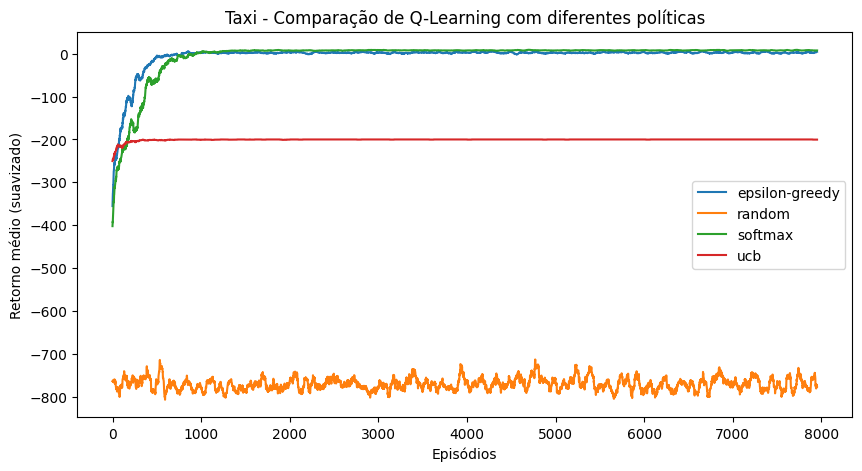

In [ ]:
# -----------------
# EXPERIMENTO 3: Taxi
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "Taxi-v3"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamento
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.95  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("Taxi - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

Taxi

Ajuste do parâmetro C para 0.1 na política UCB.

Redução inicial do número de episódios para a política UCB para 4000 (metade dos episódios).

Aumento do número de episódios de avaliação para 30 em vez de 10 para obter uma amostra maior.


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 4.0
Episódio 2: 7.0
Episódio 3: 7.0
Episódio 4: 3.0
Episódio 5: 4.0
Episódio 6: 7.0
Episódio 7: 11.0
Episódio 8: 11.0
Episódio 9: 7.0
Episódio 10: 8.0
Episódio 11: 11.0
Episódio 12: 13.0
Episódio 13: 5.0
Episódio 14: 7.0
Episódio 15: 10.0
Episódio 16: 4.0
Episódio 17: 7.0
Episódio 18: 6.0
Episódio 19: 3.0
Episódio 20: 6.0
Episódio 21: 11.0
Episódio 22: 5.0
Episódio 23: 8.0
Episódio 24: 5.0
Episódio 25: 4.0
Episódio 26: 5.0
Episódio 27: 11.0
Episódio 28: 9.0
Episódio 29: 12.0
Episódio 30: 11.0

Últimos resultados: media = 7.40, desvio padrao = 2.905168
Retorno médio (por episódio): 7.40, episódios: 30, total de passos: 408

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 8.0
Episódio 2: 6.0
Episódio 3: 7.0
Episódio 4: 8.0
Episódio 5: 9.0
Episódio 6: 10.0
Episódio 7: 7.0
Episódio 8: 6.0
Episódio 9: 10.0
Episódio 10: 8.0
Episódio 11: 7.0


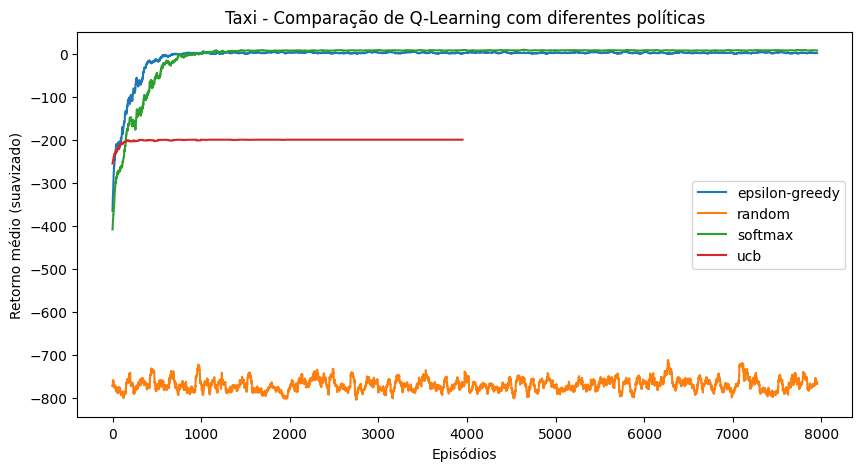

In [ ]:
# -----------------
# EXPERIMENTO 3: Taxi
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "Taxi-v3"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamento
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.95  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 0.1  # Parâmetro de exploração para a política UCB (ajustado para menor valor)

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Reduzir o número de episódios para a política UCB inicialmente
    if policy == 'ucb':
        train_rewards, Q = run_qlearning(env, EPISODES // 2, LR, GAMMA, policy, EPSILON, TAU, C)
    else:
        train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q, episodes=30)  # Aumenta o número de episódios de avaliação

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("Taxi - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico


Taxi

Diferentes valores de C para a política UCB (0.01, 0.05, 0.1).

Redução do número de episódios de treinamento para a política UCB para 2000 (um quarto dos episódios originais).

Aumento do número de episódios de avaliação para 30 para todas as políticas.


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 10.0
Episódio 2: 7.0
Episódio 3: 14.0
Episódio 4: 5.0
Episódio 5: 12.0
Episódio 6: 12.0
Episódio 7: 7.0
Episódio 8: 11.0
Episódio 9: 5.0
Episódio 10: 9.0
Episódio 11: 8.0
Episódio 12: 6.0
Episódio 13: 4.0
Episódio 14: 9.0
Episódio 15: 4.0
Episódio 16: 12.0
Episódio 17: 7.0
Episódio 18: 10.0
Episódio 19: 9.0
Episódio 20: 8.0
Episódio 21: 4.0
Episódio 22: 6.0
Episódio 23: 8.0
Episódio 24: 7.0
Episódio 25: 9.0
Episódio 26: 6.0
Episódio 27: 11.0
Episódio 28: 9.0
Episódio 29: 7.0
Episódio 30: 7.0

Últimos resultados: media = 8.10, desvio padrao = 2.573584
Retorno médio (por episódio): 8.10, episódios: 30, total de passos: 387

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 11.0
Episódio 2: 7.0
Episódio 3: 9.0
Episódio 4: 9.0
Episódio 5: 8.0
Episódio 6: 8.0
Episódio 7: 11.0
Episódio 8: 5.0
Episódio 9: 7.0
Episódio 10: 9.0
Episódio 11: 4.0
E

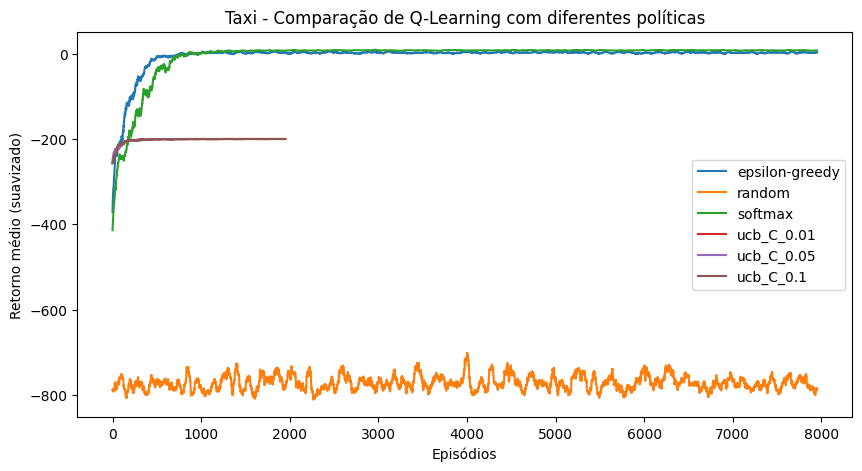

In [ ]:
# -----------------
# EXPERIMENTO 3: Taxi
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "Taxi-v3"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamento
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.95  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C_values = [0.01, 0.05, 0.1]  # Diferentes valores de C para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Reduzir ainda mais o número de episódios para a política UCB e testar diferentes valores de C
    if policy == 'ucb':
        for C in C_values:
            print(f"Testando política UCB com C = {C}")
            train_rewards, Q = run_qlearning(env, EPISODES // 4, LR, GAMMA, policy, EPSILON, TAU, C)
            results[f"{policy}_C_{C}"] = train_rewards
            print(f"\n{policy} - Avaliação da política greedy com C = {C}:")
            test_returns[f"{policy}_C_{C}"] = evaluate_policy(env, Q, episodes=30)  # Aumenta o número de episódios de avaliação
    else:
        train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C_values[0])
        results[policy] = train_rewards
        print(f"\n{policy} - Avaliação da política greedy:")
        test_returns[policy] = evaluate_policy(env, Q, episodes=30)  # Aumenta o número de episódios de avaliação

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    if policy == 'ucb':
        for C in C_values:
            plt.plot(np.convolve(results[f"{policy}_C_{C}"], np.ones(50)/50, mode='valid'), label=f"{policy}_C_{C}")
    else:
        plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("Taxi - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico


Taxi

mudando o valor de GAMMA para 0.9.


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 7.0
Episódio 2: 6.0
Episódio 3: 9.0
Episódio 4: 9.0
Episódio 5: 5.0
Episódio 6: 7.0
Episódio 7: 8.0
Episódio 8: 12.0
Episódio 9: 5.0
Episódio 10: 10.0

Últimos resultados: media = 7.80, desvio padrao = 2.135416
Retorno médio (por episódio): 7.80, episódios: 10, total de passos: 132

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 9.0
Episódio 2: 9.0
Episódio 3: 6.0
Episódio 4: 8.0
Episódio 5: 11.0
Episódio 6: 6.0
Episódio 7: 6.0
Episódio 8: 9.0
Episódio 9: 5.0
Episódio 10: 8.0

Últimos resultados: media = 7.70, desvio padrao = 1.791647
Retorno médio (por episódio): 7.70, episódios: 10, total de passos: 133

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 8.0
Episódio 2: 10.0
Episódio 3: 7.0
Episódio 4: 12.0
Episódio 5: 10.0
Episódio 6: 9.0
Episódio 7: 12.0
Episódio 8: 9.0
Episódio 9: 11.0
E

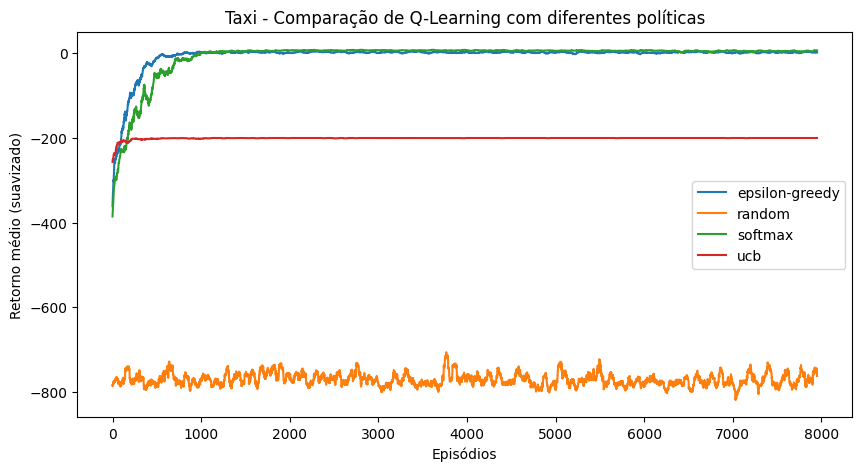

In [ ]:
# -----------------
# EXPERIMENTO 3: Taxi
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "Taxi-v3"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamento
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.9  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("Taxi - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

Taxi

Mudando valor de GAMMA para 0.99


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 9.0
Episódio 2: 10.0
Episódio 3: 8.0
Episódio 4: 7.0
Episódio 5: 8.0
Episódio 6: 5.0
Episódio 7: 8.0
Episódio 8: 15.0
Episódio 9: 4.0
Episódio 10: 11.0

Últimos resultados: media = 8.50, desvio padrao = 2.941088
Retorno médio (por episódio): 8.50, episódios: 10, total de passos: 125

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 11.0
Episódio 2: 8.0
Episódio 3: 6.0
Episódio 4: 11.0
Episódio 5: 5.0
Episódio 6: 9.0
Episódio 7: 10.0
Episódio 8: 8.0
Episódio 9: 10.0
Episódio 10: 7.0

Últimos resultados: media = 8.50, desvio padrao = 1.962142
Retorno médio (por episódio): 8.50, episódios: 10, total de passos: 125

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 7.0
Episódio 2: 8.0
Episódio 3: 9.0
Episódio 4: 7.0
Episódio 5: 11.0
Episódio 6: 8.0
Episódio 7: 10.0
Episódio 8: 8.0
Episódio 9: 7.0


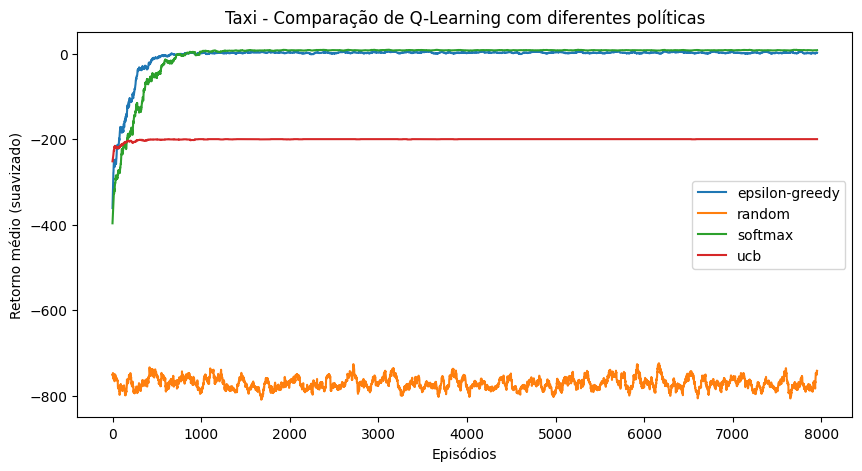

In [ ]:
# -----------------
# EXPERIMENTO 3: Taxi
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "Taxi-v3"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamento
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.99  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("Taxi - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

FrozenLake

Mudando o GAMMA para 0.9


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 0.0
Episódio 2: 1.0
Episódio 3: 0.0
Episódio 4: 0.0
Episódio 5: 0.0
Episódio 6: 1.0
Episódio 7: 1.0
Episódio 8: 0.0
Episódio 9: 1.0
Episódio 10: 1.0

Últimos resultados: media = 0.50, desvio padrao = 0.500000
Retorno médio (por episódio): 0.50, episódios: 10, total de passos: 289

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 0.0
Episódio 2: 0.0
Episódio 3: 0.0
Episódio 4: 0.0
Episódio 5: 0.0
Episódio 6: 0.0
Episódio 7: 0.0
Episódio 8: 1.0
Episódio 9: 0.0
Episódio 10: 0.0

Últimos resultados: media = 0.10, desvio padrao = 0.300000
Retorno médio (por episódio): 0.10, episódios: 10, total de passos: 286

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 1.0
Episódio 2: 1.0
Episódio 3: 0.0
Episódio 4: 0.0
Episódio 5: 1.0
Episódio 6: 0.0
Episódio 7: 0.0
Episódio 8: 1.0
Episódio 9: 0.0
Episódio 

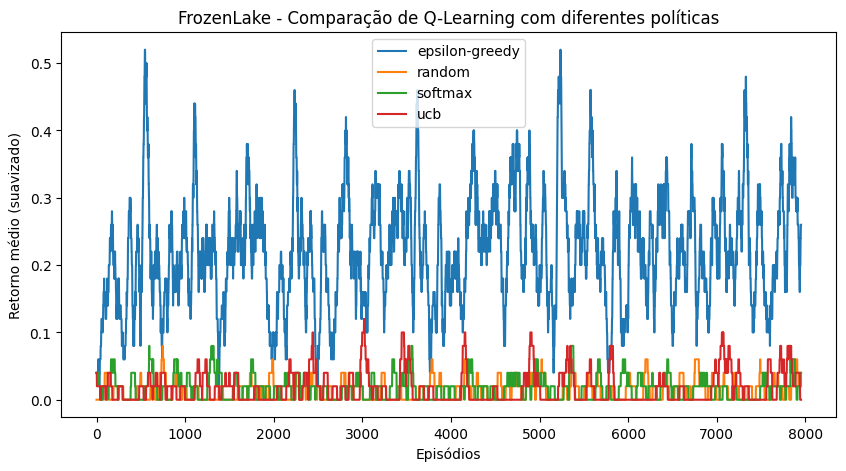

In [ ]:
# -----------------
# EXPERIMENTO 1: FrozenLake
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "FrozenLake-v1"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamentoa
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.9  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("FrozenLake - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

FrozenLake

Mudando o GAMMA para 0.99


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 1.0
Episódio 2: 0.0
Episódio 3: 1.0
Episódio 4: 1.0
Episódio 5: 1.0
Episódio 6: 1.0
Episódio 7: 1.0
Episódio 8: 0.0
Episódio 9: 0.0
Episódio 10: 1.0

Últimos resultados: media = 0.70, desvio padrao = 0.458258
Retorno médio (por episódio): 0.70, episódios: 10, total de passos: 341

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 0.0
Episódio 2: 0.0
Episódio 3: 0.0
Episódio 4: 0.0
Episódio 5: 0.0
Episódio 6: 0.0
Episódio 7: 0.0
Episódio 8: 0.0
Episódio 9: 0.0
Episódio 10: 0.0

Últimos resultados: media = 0.00, desvio padrao = 0.000000
Retorno médio (por episódio): 0.00, episódios: 10, total de passos: 168

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 1.0
Episódio 2: 1.0
Episódio 3: 1.0
Episódio 4: 1.0
Episódio 5: 1.0
Episódio 6: 0.0
Episódio 7: 1.0
Episódio 8: 0.0
Episódio 9: 0.0
Episódio 

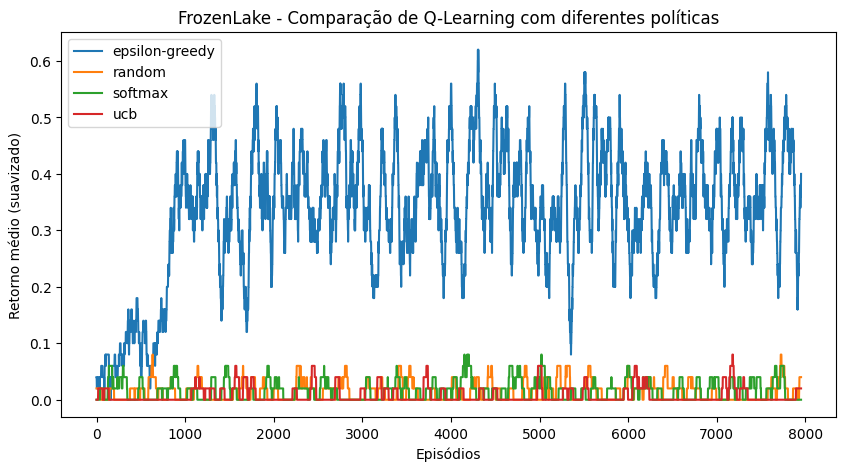

In [ ]:
# -----------------
# EXPERIMENTO 1: FrozenLake
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "FrozenLake-v1"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamentoa
LR = 0.2  # Taxa de aprendizado (learning rate)
GAMMA = 0.99  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("FrozenLake - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

FrozenLake

Mudando o GAMMA para 0.99 e Taxa de aprendizado para 0.5


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 1.0
Episódio 2: 0.0
Episódio 3: 1.0
Episódio 4: 1.0
Episódio 5: 1.0
Episódio 6: 1.0
Episódio 7: 1.0
Episódio 8: 1.0
Episódio 9: 1.0
Episódio 10: 1.0

Últimos resultados: media = 0.90, desvio padrao = 0.300000
Retorno médio (por episódio): 0.90, episódios: 10, total de passos: 383

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 0.0
Episódio 2: 0.0
Episódio 3: 1.0
Episódio 4: 1.0
Episódio 5: 1.0
Episódio 6: 1.0
Episódio 7: 1.0
Episódio 8: 0.0
Episódio 9: 0.0
Episódio 10: 0.0

Últimos resultados: media = 0.50, desvio padrao = 0.500000
Retorno médio (por episódio): 0.50, episódios: 10, total de passos: 401

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 0.0
Episódio 2: 0.0
Episódio 3: 0.0
Episódio 4: 0.0
Episódio 5: 0.0
Episódio 6: 0.0
Episódio 7: 0.0
Episódio 8: 1.0
Episódio 9: 0.0
Episódio 

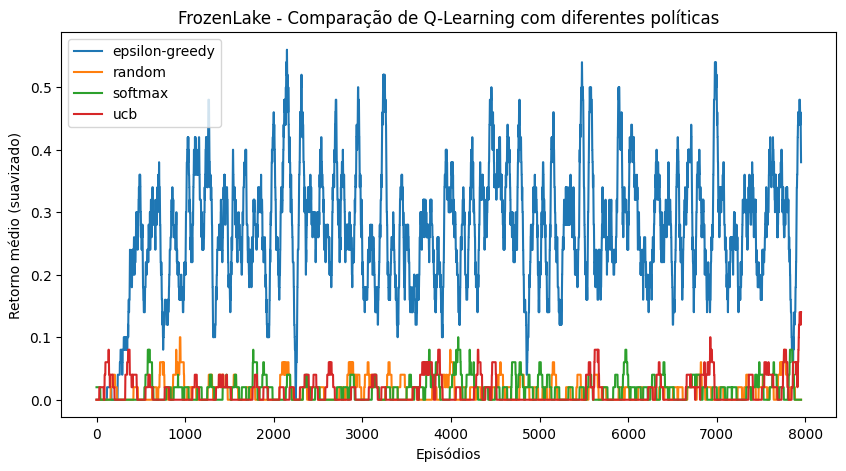

In [ ]:
# -----------------
# EXPERIMENTO 1: FrozenLake
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "FrozenLake-v1"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamentoa
LR = 0.5  # Taxa de aprendizado (learning rate)
GAMMA = 0.99  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("FrozenLake - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

Taxi

Mudando o GAMMA para 0.99 e Taxa de aprendizado para 0.5


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 11.0
Episódio 2: 11.0
Episódio 3: 9.0
Episódio 4: 6.0
Episódio 5: 12.0
Episódio 6: 14.0
Episódio 7: 13.0
Episódio 8: 4.0
Episódio 9: 5.0
Episódio 10: 6.0

Últimos resultados: media = 9.10, desvio padrao = 3.419064
Retorno médio (por episódio): 9.10, episódios: 10, total de passos: 119

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 7.0
Episódio 2: 6.0
Episódio 3: 5.0
Episódio 4: 10.0
Episódio 5: 11.0
Episódio 6: 8.0
Episódio 7: 5.0
Episódio 8: 10.0
Episódio 9: 8.0
Episódio 10: 11.0

Últimos resultados: media = 8.10, desvio padrao = 2.211334
Retorno médio (por episódio): 8.10, episódios: 10, total de passos: 129

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 9.0
Episódio 2: 3.0
Episódio 3: 9.0
Episódio 4: 11.0
Episódio 5: 9.0
Episódio 6: 10.0
Episódio 7: 4.0
Episódio 8: 11.0
Episódio 9: 7

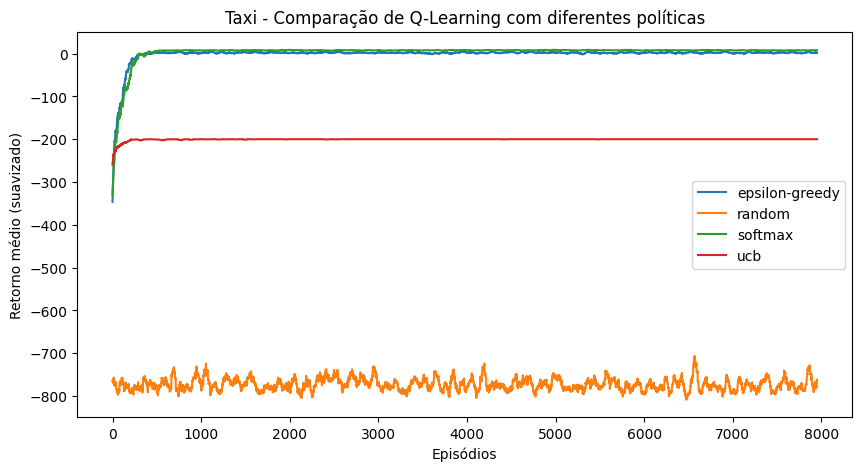

In [ ]:
# -----------------
# EXPERIMENTO 3: Taxi
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "Taxi-v3"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamento
LR = 0.5  # Taxa de aprendizado (learning rate)
GAMMA = 0.99  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("Taxi - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

Taxi

Mudando o GAMMA para 0.99 e Taxa de aprendizado para 0.35


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 4.0
Episódio 2: 3.0
Episódio 3: 11.0
Episódio 4: 11.0
Episódio 5: 4.0
Episódio 6: 6.0
Episódio 7: 9.0
Episódio 8: 11.0
Episódio 9: 3.0
Episódio 10: 4.0

Últimos resultados: media = 6.60, desvio padrao = 3.322650
Retorno médio (por episódio): 6.60, episódios: 10, total de passos: 144

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 11.0
Episódio 2: 4.0
Episódio 3: 5.0
Episódio 4: 9.0
Episódio 5: 5.0
Episódio 6: 12.0
Episódio 7: 7.0
Episódio 8: 10.0
Episódio 9: 9.0
Episódio 10: 12.0

Últimos resultados: media = 8.40, desvio padrao = 2.835489
Retorno médio (por episódio): 8.40, episódios: 10, total de passos: 126

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 9.0
Episódio 2: 3.0
Episódio 3: 12.0
Episódio 4: 3.0
Episódio 5: 6.0
Episódio 6: 11.0
Episódio 7: 4.0
Episódio 8: 6.0
Episódio 9: 5.0


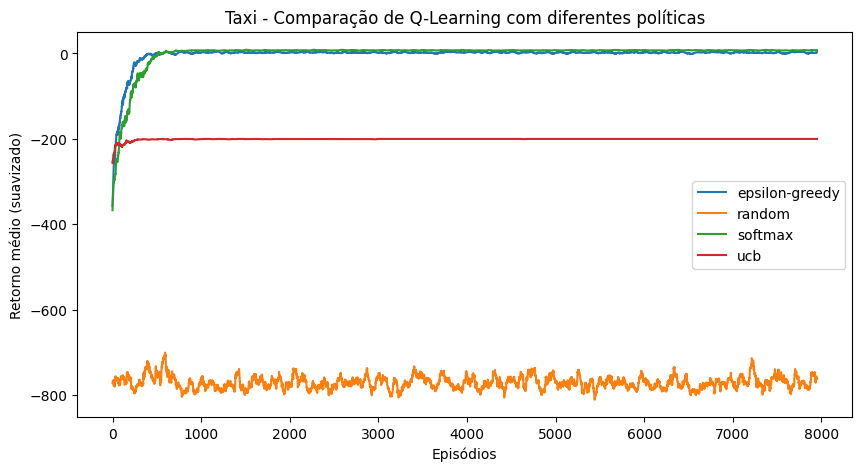

In [ ]:
# -----------------
# EXPERIMENTO 3: Taxi
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "Taxi-v3"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamento
LR = 0.35  # Taxa de aprendizado (learning rate)
GAMMA = 0.99  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("Taxi - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico

Frozenlake

Mudando o GAMMA para 0.99 e Taxa de aprendizado para 0.35


Rodando Q-Learning com política: epsilon-greedy

epsilon-greedy - Avaliação da política greedy:
Episódio 1: 1.0
Episódio 2: 1.0
Episódio 3: 1.0
Episódio 4: 1.0
Episódio 5: 0.0
Episódio 6: 1.0
Episódio 7: 1.0
Episódio 8: 1.0
Episódio 9: 1.0
Episódio 10: 1.0

Últimos resultados: media = 0.90, desvio padrao = 0.300000
Retorno médio (por episódio): 0.90, episódios: 10, total de passos: 443

Rodando Q-Learning com política: random

random - Avaliação da política greedy:
Episódio 1: 1.0
Episódio 2: 1.0
Episódio 3: 1.0
Episódio 4: 1.0
Episódio 5: 1.0
Episódio 6: 1.0
Episódio 7: 0.0
Episódio 8: 1.0
Episódio 9: 1.0
Episódio 10: 1.0

Últimos resultados: media = 0.90, desvio padrao = 0.300000
Retorno médio (por episódio): 0.90, episódios: 10, total de passos: 386

Rodando Q-Learning com política: softmax

softmax - Avaliação da política greedy:
Episódio 1: 1.0
Episódio 2: 0.0
Episódio 3: 0.0
Episódio 4: 1.0
Episódio 5: 0.0
Episódio 6: 0.0
Episódio 7: 0.0
Episódio 8: 0.0
Episódio 9: 1.0
Episódio 

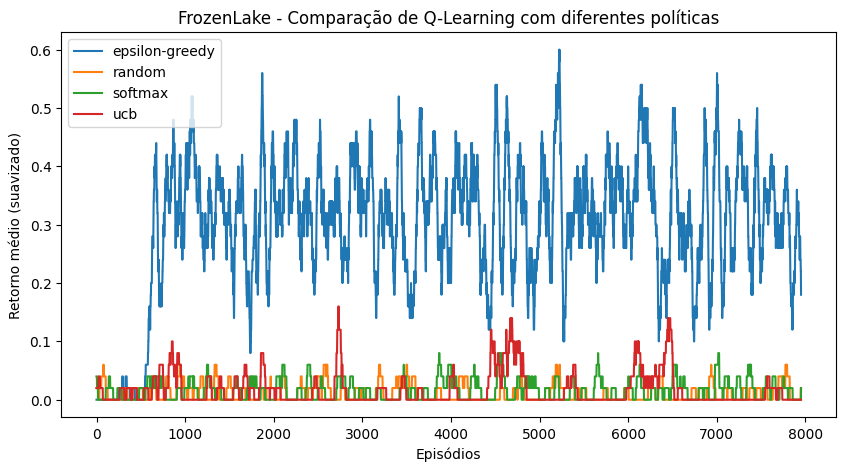

In [ ]:
# -----------------
# EXPERIMENTO 1: FrozenLake
# -----------------

# Definição do ambiente e dos hiperparâmetros do treinamento
ENV_NAME = "FrozenLake-v1"  # Nome do ambiente do Gymnasium
EPISODES = 8000  # Número de episódios de treinamentoa
LR = 0.35  # Taxa de aprendizado (learning rate)
GAMMA = 0.99  # Fator de desconto para recompensas futuras
EPSILON = 0.1  # Probabilidade de exploração para a política epsilon-greedy
TAU = 1.0  # Parâmetro de temperatura para a política Softmax
C = 2.0  # Parâmetro de exploração para a política UCB

# Criação do ambiente
env = gym.make(ENV_NAME)

# Lista de políticas a serem comparadas
policies = ['epsilon-greedy', 'random', 'softmax', 'ucb']

# Dicionários para armazenar os resultados do treinamento e dos testes
results = {}  # Armazena os retornos acumulados durante o treinamento
test_returns = {}  # Armazena os retornos médios durante a avaliação

# Loop para treinar e avaliar Q-Learning com cada política
for policy in policies:
    print(f"\nRodando Q-Learning com política: {policy}")

    # Treina o agente usando a política especificada
    train_rewards, Q = run_qlearning(env, EPISODES, LR, GAMMA, policy, EPSILON, TAU, C)

    # Armazena os resultados do treinamento
    results[policy] = train_rewards

    # Avalia a política aprendida usando a estratégia greedy
    print(f"\n{policy} - Avaliação da política greedy:")
    test_returns[policy] = evaluate_policy(env, Q)

# -----------------
# PLOTAGEM DOS RESULTADOS
# -----------------

# Cria um gráfico para visualizar o desempenho das diferentes políticas
plt.figure(figsize=(10, 5))

for policy in policies:
    # Suaviza os retornos usando uma média móvel (janela de 50 episódios)
    plt.plot(np.convolve(results[policy], np.ones(50)/50, mode='valid'), label=policy)

plt.xlabel("Episódios")  # Rótulo do eixo X
plt.ylabel("Retorno médio (suavizado)")  # Rótulo do eixo Y
plt.title("FrozenLake - Comparação de Q-Learning com diferentes políticas")  # Título do gráfico
plt.legend()  # Adiciona a legenda para identificar as políticas
plt.show()  # Exibe o gráfico